In [15]:
# ─────────────────────────────────────────────
# 0 : Loading
# ─────────────────────────────────────────────

%reload_ext autoreload
%autoreload 2

In [16]:
# ─────────────────────────────────────────────
# 1.1 : Python Version
# ─────────────────────────────────────────────

import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")


# ─────────────────────────────────────────────
# 1.2 : Librairies
# ─────────────────────────────────────────────

import pickle
import numpy as np
import polars as pl
import pyarrow.parquet as pq

from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm

from nucleo.io.reading import getting_main_file_with_verifications

Python: /home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/bin/python
User site: /home/nicolas/.local/lib/python3.12/site-packages
Site-packages: ['/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3.12/site-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/local/lib/python3.12/dist-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3/dist-packages', '/home/nicolas/Documents/Workspace/nucleo/.venv_nucleo_3.12.3/lib/python3.12/dist-packages']


In [17]:
# ─────────────────────────────────────────────
# 2.1 : Main file + Verification
# ─────────────────────────────────────────────

# Reading it for further manipulations
main_file_path = Path.home() / "Documents" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "ncl_output.parquet"
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)

# Loading file + Filtering
df_main = getting_main_file_with_verifications(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_main.shape, '\nQuick print and shape :', df_main.head(5))

The df_polars containing the int and floats for all our simulations :
Total shape : (131300, 27) 
Quick print and shape : shape: (5, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬───────────┬────────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean   ┆ vi_med     ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---       ┆ ---        ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64       ┆ f64        ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪═══════════╪════════════╪═══════╡
│ nt_random    ┆ 150 ┆ 10  ┆ 5     ┆ … ┆ 0.004  ┆ 40.681776 ┆ 1.052138   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 5     ┆ … ┆ 0.0    ┆ 0.002384  ┆ 1.9735e-39 ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 5     ┆ … ┆ 0.0    ┆ 0.009834  ┆ 1.2534e-32 ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 5     ┆ … ┆ 0.0    ┆ 0.033726  ┆ 3.0749e-27 ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 5     ┆ … ┆ 0.071  ┆ 0.145566  ┆ 5.4905e-23 ┆ 0.5   │
└──────────────┴─────┴─────┴─────

Plotting heatmaps: 100%|██████████| 13/13 [00:00<00:00, 19.88it/s]


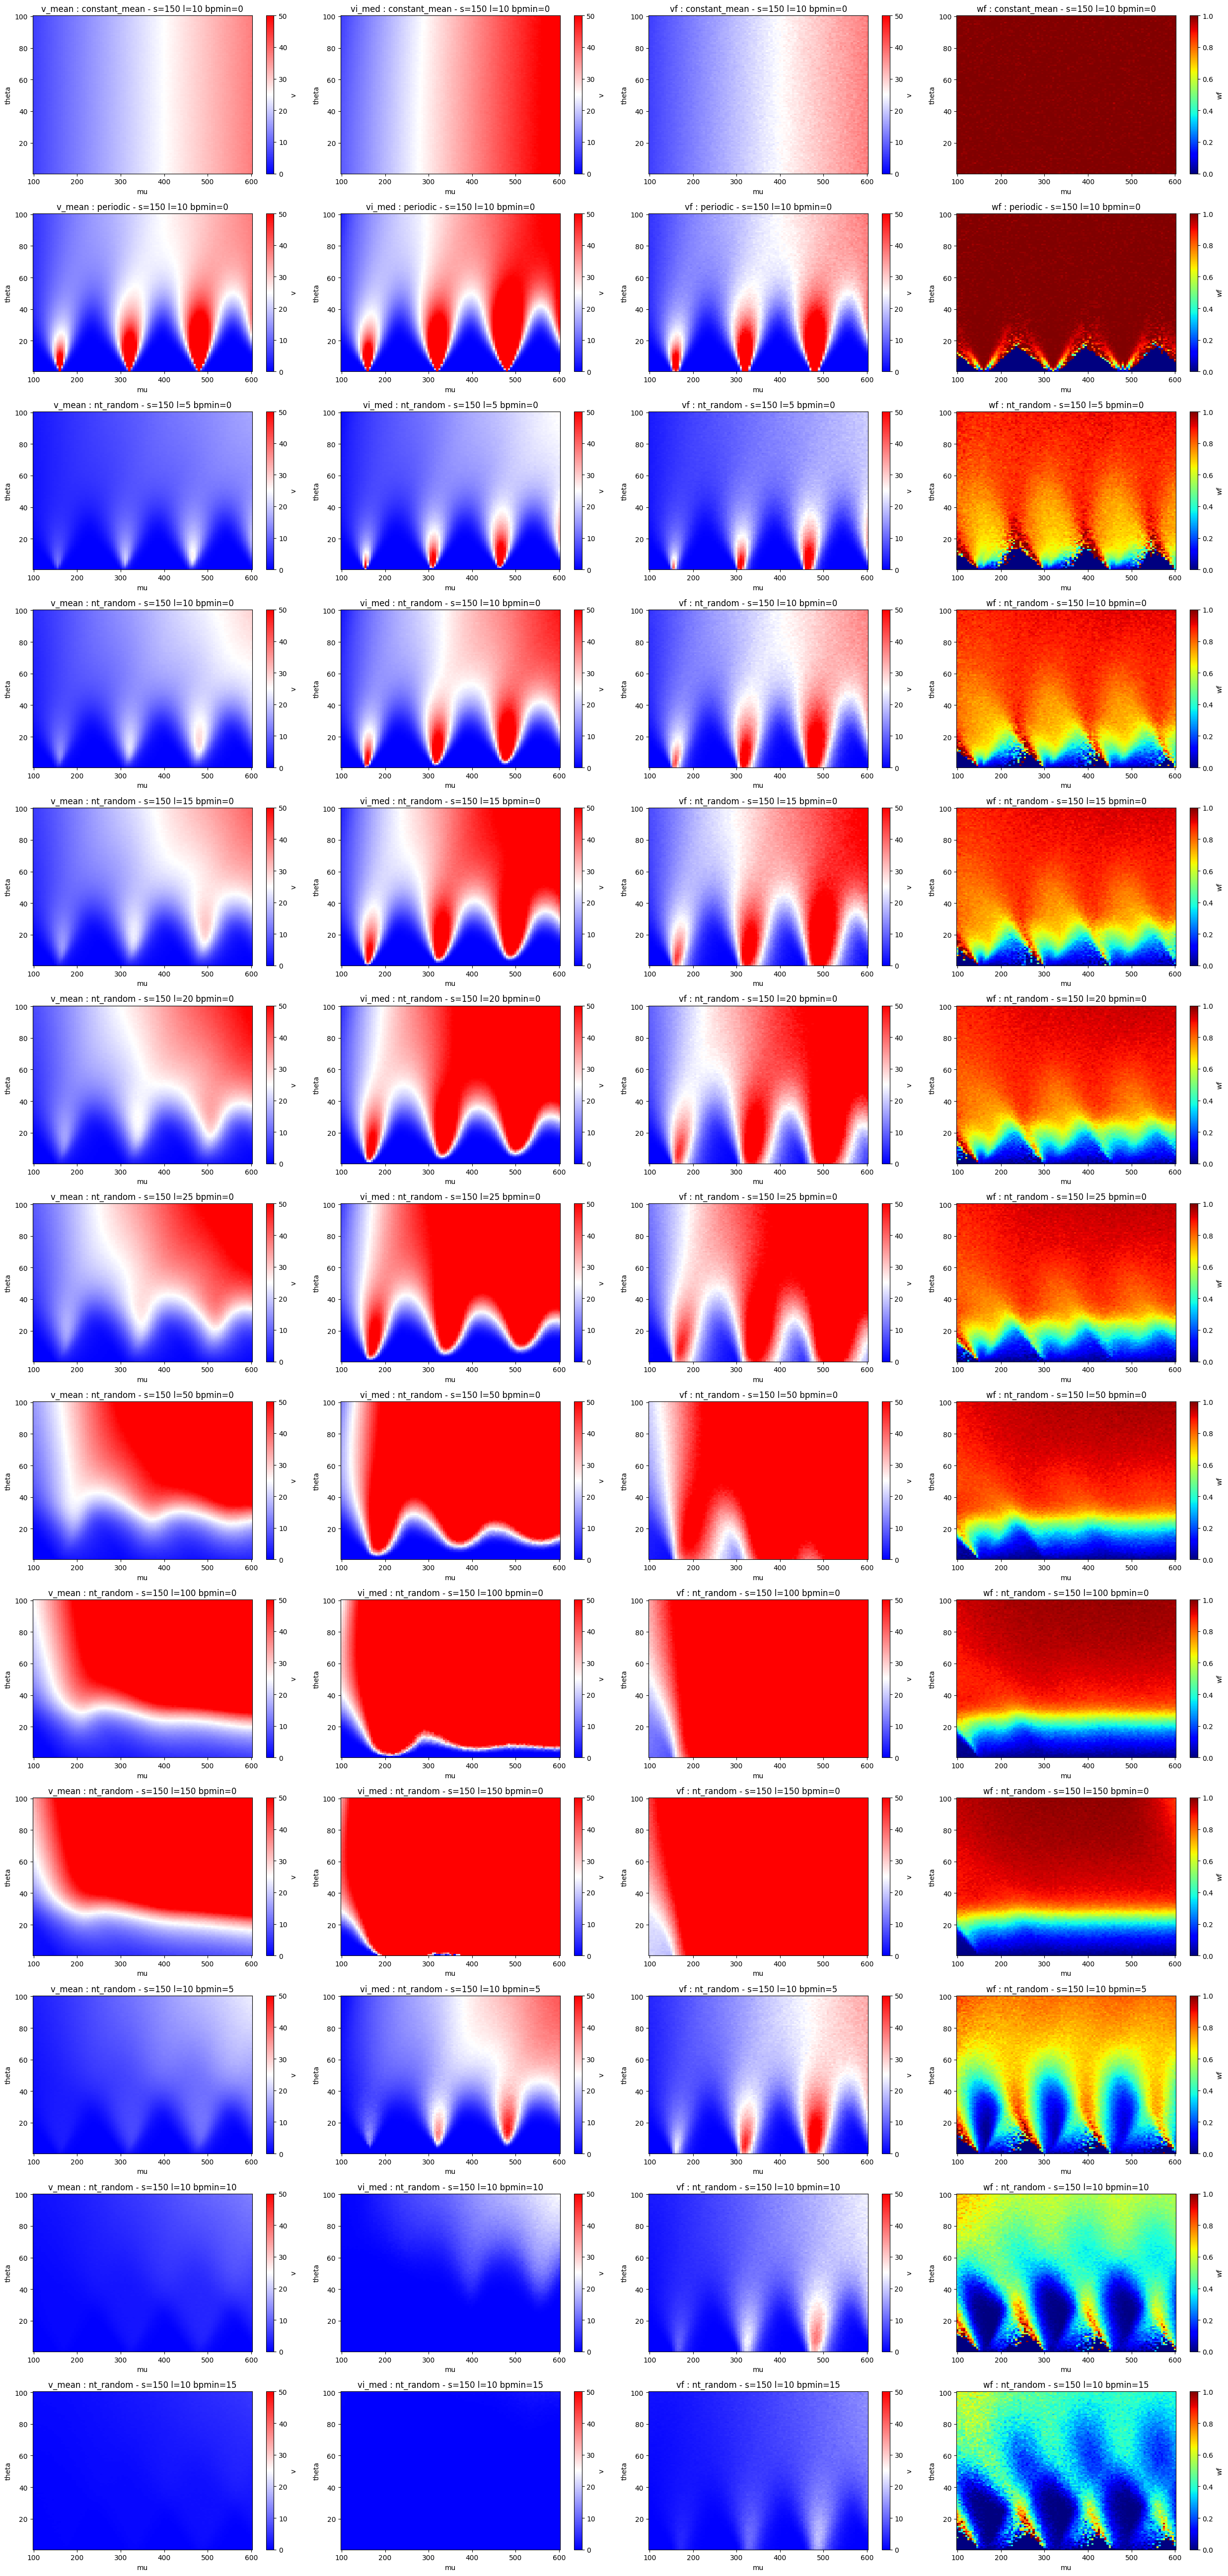

In [26]:
# ─────────────────────────────────────────────
# 2.2 : Heatmaps
# ─────────────────────────────────────────────

def ncl_plot_precomputed_heatmaps(speed_cols, root = Path.home() / "Documents" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN", type_of_data="raw", plot_log2=False):
    """
    Plots heatmaps of either raw or log2-transformed values depending on the variable:
    - log2 + bwr for all except wf
    - linear + jet for wf

    Data are already normalized by the theoretical values of the constant_value scenario !

    """

    if plot_log2:
        title_bar_mini = "log₂ "
    else:
        title_bar_mini = ""

    if type_of_data not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError ("No such type_of_data possible to plot.")

    if type_of_data == "raw":
        main_file_path = root / "ncl_hm_raw.pkl"
        title_bar = title_bar_mini + "v"
        if plot_log2:
            vmin, vmax = -2, 10
        else :
            vmin, vmax = 0, 50

    elif type_of_data == "norm_mu":
        main_file_path = root / "ncl_hm_nmu.pkl"
        title_bar = title_bar_mini + "(v / mean value)"
        if plot_log2:
            vmin, vmax = -1, 0.010
        else:
            vmin, vmax = 0, 0.50

    elif type_of_data == "norm_th":
        main_file_path = root / "ncl_hm_nth.pkl"
        title_bar = title_bar_mini + "(v / theoretical value)"
        if plot_log2:
            vmin, vmax = -2, 2
        else:
            vmin, vmax = 0, 10

    with open(main_file_path, "rb") as f:
        computed_data = pickle.load(f)

    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)

    for idx, (key, config_data) in enumerate(tqdm(computed_data.items(), total=n_combinations, desc="Plotting heatmaps")):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]
            data = config_data[speed_col]

            if speed_col == "wf":
                cmap = 'jet'
                wmin = 0
                wmax = 1
                data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=wmin, vmax=wmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(f"{speed_col}")

            else:
                cmap = 'bwr'
                if plot_log2: 
                    data_to_fix = np.log2(data, dtype=float)
                    data_to_plot = np.nan_to_num(data_to_fix, nan=0.0)
                else:
                    data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=vmin, vmax=vmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(title_bar)

            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

    plt.tight_layout()
    plt.show()


# --- Load Data and Plot --- #
ncl_plot_precomputed_heatmaps(
    # speed_cols=["v_mean", "vi_med", "vi_mp", "vf", "wf"]
    speed_cols=["v_mean", "vi_med", "vf", "wf"],
    type_of_data = "raw",
    plot_log2=False
)

# .